<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/A_Journey_into_the_Depths_of_Neural_Networks/blob/master/A_Neuron_Dancing_in_Logistic_Regression_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Neuron Dancing in Logistic Regression Style**

## **Libraries**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

## **Loading Dataset and Normalization**

In [2]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## **Relabeling Data**

In [3]:
# Label 0 is for airplane
y_train = np.where(y_train == 0, 0, 1)
y_test = np.where(y_test == 0, 0, 1)

print("y_train:")
print(y_train[160:170])

print("y_test:")
print(y_test[160:170])

y_train:
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]]
y_test:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


## **Flatten and Reshape Images**

In [4]:
# reshape images from (32, 32, 3) to (3072,)
X_train = X_train.reshape((X_train.shape[0], -1))  # (50000, 3072)
X_test = X_test.reshape((X_test.shape[0], -1))     # (10000, 3072)

y_train, y_test = y_train.flatten(), y_test.flatten() # (50000,  -   10000,)

## **Model**

### **Activation Function : Sigmoid and Relu**

In [5]:
class Activation:
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(a):
        return a * (1 - a)

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

## **Neural Network**

### **Dence Layer Class**

In [6]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation='sigmoid'):
        self.w = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
        self.activation_name = activation
        self.z = None
        self.a = None
        self.input = None

    def forward(self, x):
        self.input = x
        self.z = np.dot(x, self.w) + self.b
        if self.activation_name == 'sigmoid':
            self.a = Activation.sigmoid(self.z)
        elif self.activation_name == 'relu':
            self.a = Activation.relu(self.z)
        return self.a

    def backward(self, da, lr):
        m = self.input.shape[0]
        if self.activation_name == 'sigmoid':
            dz = da * Activation.sigmoid_derivative(self.a)
        elif self.activation_name == 'relu':
            dz = da * Activation.relu_derivative(self.z)

        dw = np.dot(self.input.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        da_prev = np.dot(dz, self.w.T)

        self.w -= lr * dw
        self.b -= lr * db

        return da_prev

### **Neural Network Class**

In [7]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-8
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

    def backward(self, y_true, y_pred, lr):
        da = -(np.divide(y_true, y_pred + 1e-8) - np.divide(1 - y_true, 1 - y_pred + 1e-8))
        for layer in reversed(self.layers):
            da = layer.backward(da, lr)

    def train(self, X, y, epochs=100, lr=0.01, batch_size=64, verbose=True):
        for epoch in range(epochs):
            # ✅ Shuffle the data at the beginning of each epoch
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = []

            # ✅ Mini-batch gradient descent
            for i in range(0, X.shape[0], batch_size):
                x_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size].reshape(-1, 1)

                # Forward pass
                output = x_batch
                for layer in self.layers:
                    output = layer.forward(output)

                # ✅ Derivative of binary cross-entropy with sigmoid output (dz = a - y)
                dz = output - y_batch
                gradient = dz

                # Backward pass
                for layer in reversed(self.layers):
                    gradient = layer.backward(gradient, lr)

                # Compute batch loss
                batch_loss = np.mean(
                    -y_batch * np.log(output + 1e-8) - (1 - y_batch) * np.log(1 - output + 1e-8)
                )
                epoch_loss.append(batch_loss)

            # ✅ Print average loss per epoch
            if verbose and epoch % 10 == 0:
                avg_loss = np.mean(epoch_loss)
                print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")


    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred >= 0.5).astype(int)

## **Main**

In [8]:
model = NeuralNetwork()
model.add(DenseLayer(3072, 1, activation='sigmoid'))

model.train(X_train, y_train, epochs=1000, lr=0.01, batch_size=64)
predictions = model.predict(X_test)

Epoch 0: Loss = 0.3539
Epoch 10: Loss = 0.2954
Epoch 20: Loss = 0.2892
Epoch 30: Loss = 0.2849
Epoch 40: Loss = 0.2814
Epoch 50: Loss = 0.2782
Epoch 60: Loss = 0.2749
Epoch 70: Loss = 0.2726
Epoch 80: Loss = 0.2708
Epoch 90: Loss = 0.2685
Epoch 100: Loss = 0.2669
Epoch 110: Loss = 0.2656
Epoch 120: Loss = 0.2637
Epoch 130: Loss = 0.2623
Epoch 140: Loss = 0.2614
Epoch 150: Loss = 0.2598
Epoch 160: Loss = 0.2589
Epoch 170: Loss = 0.2582
Epoch 180: Loss = 0.2574
Epoch 190: Loss = 0.2565
Epoch 200: Loss = 0.2557
Epoch 210: Loss = 0.2554
Epoch 220: Loss = 0.2548
Epoch 230: Loss = 0.2544
Epoch 240: Loss = 0.2536
Epoch 250: Loss = 0.2529
Epoch 260: Loss = 0.2523
Epoch 270: Loss = 0.2520
Epoch 280: Loss = 0.2515
Epoch 290: Loss = 0.2510
Epoch 300: Loss = 0.2507
Epoch 310: Loss = 0.2506
Epoch 320: Loss = 0.2500
Epoch 330: Loss = 0.2501
Epoch 340: Loss = 0.2497
Epoch 350: Loss = 0.2495
Epoch 360: Loss = 0.2492
Epoch 370: Loss = 0.2488
Epoch 380: Loss = 0.2487
Epoch 390: Loss = 0.2483
Epoch 400: 

## **Calculation and Evaluation**

Confusion Matrix:
 [[ 264  736]
 [ 134 8866]]


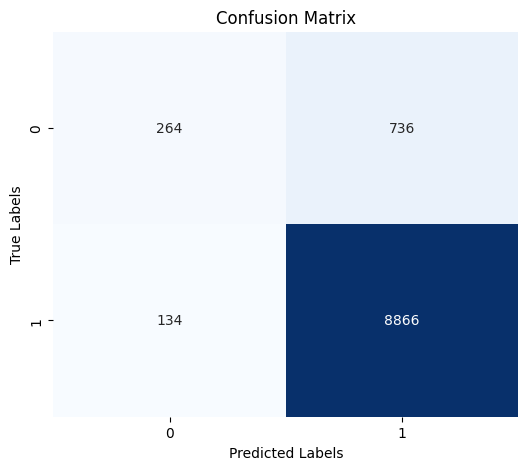

F1 Score: 0.9532308353940436
Accuracy: 0.913
Precision: 0.9233493022287024
Recall: 0.9851111111111112


In [11]:
# Predictions
predictions_binary = (predictions >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# F1 Score
f1 = f1_score(y_test, predictions_binary)
print("F1 Score:", f1)

# Optional: Accuracy, Precision, Recall
acc = accuracy_score(y_test, predictions_binary)
prec = precision_score(y_test, predictions_binary)
rec = recall_score(y_test, predictions_binary)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)